## Figure 1: plot_full_cartoon of LABLDH


In [15]:
%matplotlib inline
from JAMA_config import *

In [16]:
data_source = 'Stanford'
lab_type = 'panel'

In [17]:
dataSet_foldername = 'data-%s-%s-%s'%(data_source, 
                                      lab_type, 
                                      curr_version)
dataML_folderpath = os.path.join(ML_folderpath, dataSet_foldername)
dataStats_folderpath = os.path.join(stats_folderpath, dataSet_foldername)

all_labs = stats_utils.get_all_labs(data_source, lab_type)

lab_descriptions = stats_utils.get_lab_descriptions(data_source=data_source, 
                                                   lab_type=lab_type)

In [18]:
figure2_folderpath = os.path.join(stats_folderpath, 'Fig2_Order_Intensities')

## Order_Intensities

In [19]:

labs_cnts_order_1day = stats_database.TOP_PANELS_AND_COUNTS_IN_1DAY[:20]
labs_order_1day = [x[0] for x in labs_cnts_order_1day]

labs_guideline = ['LABESRP', 'LABALB', 'LABA1C', 'LABTSH', 'LABCRP', 'LABYCP', 'LABLIPS', 'LABAGALA', 'LABNTBNP']


use_cached_fig_data = True
DEFAULT_TIMELIMIT = stats_utils.DEFAULT_TIMELIMIT



scale = 1. / stats_utils.NUM_DISTINCT_ENCS * 1000



to_annotate_percentages=False

cached_result_foldername = os.path.join(stats_folderpath, 'Fig2_Order_Intensities/')
if not os.path.exists(cached_result_foldername):
    os.mkdir(cached_result_foldername)

In [20]:
params_1 = {'labs':labs_order_1day,
            'result_label':'labs_order_1day',
            'scale_method' : 'by_scale',
            'include_legend':True
           }

params_2 = {'labs':labs_guideline,
            'result_label':'labs_guideline',
            'scale_method' : 'normalize',
            'include_legend':False
           }

params = params_1

labs = params['labs'] #  # 
print "Labs to be plot:", labs
result_label= params['result_label'] # 'labs_guideline'# 


scale_method=params['scale_method']
include_legend=params['include_legend']




cached_result_filename = 'Order_Intensities_%s_%s.csv'%(lab_type, result_label)
cached_result_path = os.path.join(cached_result_foldername, cached_result_filename)


Labs to be plot: ['LABMETB', 'LABMGN', 'LABCBCD', 'LABLACWB', 'LABPTT', 'LABPHOS', 'LABPT', 'LABCAI', 'LABK', 'LABHEPAR', 'LABNA', 'LABTNI', 'LABLIDOL', 'LABHCTX', 'LABLDH', 'LABURIC', 'LABLAC', 'LABSPLAC', 'LABFIB', 'LABUSPG']


In [21]:
'''
Each lab 
    -> all its orders in 2014/07-2017/06 (implicit) 
    -> {time since last order:cnts} (cached)
    -> {0-1 days: cnt, 1-3 days: ...} 
    -> barh
'''
lab2stats = {}
columns = ['< 24 hrs', '[24 hrs, 3 days)', '[3 days, 1 week)', '>= 1 week']

if os.path.exists(cached_result_path) and use_cached_fig_data:
    lab2stats_pd = pd.read_csv(cached_result_path)
    lab2stats_pd = lab2stats_pd.rename(columns={'< 1 day':'< 24 hrs',
                                                '1-3 days':'[24 hrs, 3 days)',
                                                '3-7 days':'[3 days, 1 week)',
                                                '> 7 days':'>= 1 week'})
    lab2stats = lab2stats_pd.set_index('lab').to_dict(orient='index')

else:
    for lab in labs:
        print 'Getting Order Intensities of lab %s..'%lab

        df_lab = stats_utils.get_queried_lab(lab, lab_type, time_limit=DEFAULT_TIMELIMIT)

        dict_lab = stats_utils.get_floored_day_to_number_orders_cnts(lab, df_lab)

        day_counts = [0] * 4
        tot_cnt = 0
        for time, cnt in dict_lab.items():
            if 0 <= time < 1:
                day_counts[0] += cnt
            elif 1 <= time < 3:
                day_counts[1] += cnt
            elif 3 <= time < 7:
                day_counts[2] += cnt
            elif time >= 7:
                day_counts[3] += cnt
            else:
                print "time is out of range:", time
            tot_cnt += cnt

        lab2stats[lab] = dict(zip(columns, day_counts))

    df_res = pd.DataFrame.from_dict(lab2stats, orient='index').reset_index().rename(columns={'index':'lab'})

    df_res.to_csv(cached_result_path, index=False)

for lab, stats in lab2stats.items():
    stats['total'] = float(sum(stats.values()))

if scale_method == 'by_scale':
    labs_ordered = sorted(labs, key=lambda x: lab2stats[x]['total'], reverse=True) # 
else:
    labs_ordered = sorted(labs, key=lambda x: lab2stats[x]['< 24 hrs']/lab2stats[x]['total'], reverse=True)
    
labs_toplots = [labs_ordered]

In [22]:
def plot_order_intensities_barh(lab, time_since_last_order_binned, columns, scale,
                                labeling=True, lab_ind=None):

    alphas = [0.7, 1, 1, 0.7]
    colors = ['red', 'green', 'orange', 'blue']

    local_lab_descriptions = {
        'LABCBCD': 'CBC WITH\nDIFF',
        'LABPHOS': 'PHOSPHORUS\nSERUM/PLASMA',
        'LABA1C': 'HEMOGLOBIN\nA1C',
        'LABALB': 'ALBUMIN\nSERUM/PLASMA',
        'LABTSH': 'THYROID\nSIMULATING\nHORMONE',
        'LABESRP': 'SEDIMENTATION\nRATE (ESR)'
    }


    pre_sum = 0
    pre_sums = [pre_sum]
    
    for key in columns:
        pre_sum += time_since_last_order_binned[key]
        pre_sums.append(pre_sum)
    
#     print lab, time_since_last_order_binned.items()

    for i in [3,2,1,0]:
        key = columns[i]
        pre_sum = pre_sums[i+1]-pre_sums[i]
        left = pre_sums[i]

        lab_descriptions['LABTSH'] = 'TSH'
        lab_descriptions['LABESRP'] = 'Sedimentation Rate'
        lab_descriptions['LABCBCD'] = 'CBC w/ Diff'
        lab_descriptions['LABPTT'] = 'PTT'
        lab_descriptions['LABHEPAR'] = 'Heparin Activity Level'
        lab_descriptions['LABLIDOL'] = 'Lidocaine Level'
        lab_desciption = lab_descriptions.get(lab, lab)
        
        
        
#         print 'pre_sum, left:', pre_sum, left

        if labeling:
            plt.barh([lab_desciption], pre_sum, left=left, color=colors[i], alpha=alphas[i], label=key)
        else:
            plt.barh([lab_desciption], pre_sum, left=left, color=colors[i], alpha=alphas[i])

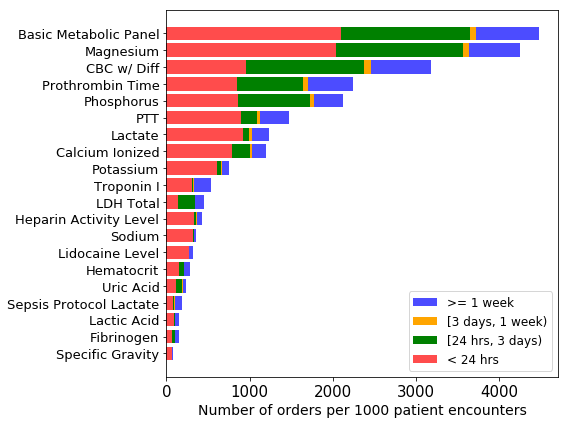

<Figure size 432x288 with 0 Axes>

In [23]:


for ind_toplot, labs_toplot in enumerate(labs_toplots):
    fig, ax = plt.subplots(figsize=(8, .3 + 5.7/20.*len(labs))) #5+ 3./20.*len(labs)
    # 8, 3.435 for guideline
    # 8, 6 for freq labs
    # 6 - 3.435 = 2.565
    # Size for saturation is 7, 2.565 ?
    for i, lab in enumerate(labs_toplot[::-1]):

        time_since_last_order_binned = lab2stats[lab]


        for time, cnt in time_since_last_order_binned.items():
            if time == 'total':
                continue
            if scale_method == 'normalize':
                time_since_last_order_binned[time] = cnt/time_since_last_order_binned['total']

            elif scale_method == 'by_scale':
                time_since_last_order_binned[time] = cnt*scale

        if i == 0:
            plot_order_intensities_barh(lab, time_since_last_order_binned,
                                             columns=columns,
                                             labeling=True,
                                             lab_ind=i,
                                             scale=scale)
        else:
            plot_order_intensities_barh(lab, time_since_last_order_binned,
                                             columns=columns,
                                             labeling=False,
                                             lab_ind=i,
                                             scale=scale)

    if scale_method == 'normalize':
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in np.linspace(0,1,num=6)])
        plt.tick_params('x', labelsize=13)
        plt.tick_params('y', labelsize=11)
        plt.xlim([0,1])
    else:
        plt.tick_params('x', labelsize=15) #12
        plt.tick_params('y', labelsize=13) #10

    if result_label != 'labs_guideline':
        plt.xlabel('Number of orders per 1000 patient encounters', fontsize=14) #'Order number between 2014/07-2017/06'

    if include_legend:
        plt.legend(prop={'size': 12})
    else:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        pass
    # plt.xscale('log')

    plt.tight_layout()
    cached_result_folderpath = cached_result_foldername + 'Order_Intensities_%s_%i_%s.png'%(lab_type,ind_toplot,result_label)

    if to_annotate_percentages:
        cached_result_folderpath.replace('.png', '_formal_1.png')
        # plt.xlim([0,5000])


    plt.savefig(cached_result_folderpath)
    plt.show()
    plt.clf()

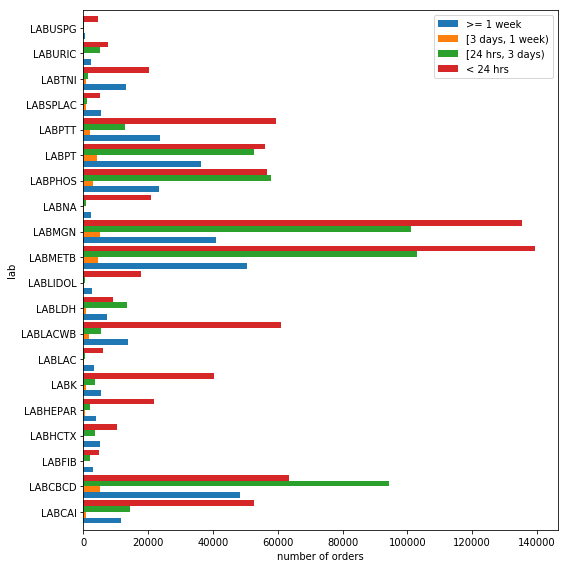

<Figure size 432x288 with 0 Axes>

In [37]:
columns_reordered = ['< 24 hrs', '[24 hrs, 3 days)', '[3 days, 1 week)', '>= 1 week'][::-1]
lab2stats_pd.set_index('lab')[columns_reordered].plot.barh(width=0.9, figsize=(8,8))
plt.xlabel('number of orders')
plt.tight_layout()

plt.show()
plt.savefig(cached_result_folderpath.replace('.png', '_unstacked.png'))
plt.clf()

## Figure 2.2

In [54]:
params_2 = {'labs':labs_guideline,
            'result_label':'labs_guideline',
            'scale_method' : 'normalize',
            'include_legend':False
           }

params = params_2

labs = params['labs'] #  # 
print "Labs to be plot:", labs
result_label= params['result_label'] # 'labs_guideline'# 


scale_method=params['scale_method']
include_legend=params['include_legend']


cached_result_filename = 'Order_Intensities_%s_%s.csv'%(lab_type, result_label)
cached_result_path = os.path.join(cached_result_foldername, cached_result_filename)

Labs to be plot: ['LABESRP', 'LABALB', 'LABA1C', 'LABTSH', 'LABCRP', 'LABYCP', 'LABLIPS', 'LABAGALA', 'LABNTBNP']


In [62]:
'''
Each lab 
    -> all its orders in 2014/07-2017/06 (implicit) 
    -> {time since last order:cnts} (cached)
    -> {0-1 days: cnt, 1-3 days: ...} 
    -> barh
'''
lab2stats = {}
columns = ['< 24 hrs', '[24 hrs, 3 days)', '[3 days, 1 week)', '>= 1 week']

if os.path.exists(cached_result_path) and use_cached_fig_data:
    lab2stats_pd = pd.read_csv(cached_result_path)
    lab2stats_pd = lab2stats_pd.rename(columns={'< 1 day':'< 24 hrs',
                                                '1-3 days':'[24 hrs, 3 days)',
                                                '3-7 days':'[3 days, 1 week)',
                                                '> 7 days':'>= 1 week'})
    lab2stats = lab2stats_pd.set_index('lab').to_dict(orient='index')

else:
    for lab in labs:
        print 'Getting Order Intensities of lab %s..'%lab

        df_lab = stats_utils.get_queried_lab(lab, lab_type, time_limit=DEFAULT_TIMELIMIT)

        dict_lab = stats_utils.get_floored_day_to_number_orders_cnts(lab, df_lab)

        day_counts = [0] * 4
        tot_cnt = 0
        for time, cnt in dict_lab.items():
            if 0 <= time < 1:
                day_counts[0] += cnt
            elif 1 <= time < 3:
                day_counts[1] += cnt
            elif 3 <= time < 7:
                day_counts[2] += cnt
            elif time >= 7:
                day_counts[3] += cnt
            else:
                print "time is out of range:", time
            tot_cnt += cnt

        lab2stats[lab] = dict(zip(columns, day_counts))

    df_res = pd.DataFrame.from_dict(lab2stats, orient='index').reset_index().rename(columns={'index':'lab'})

    df_res.to_csv(cached_result_path, index=False)

for lab, stats in lab2stats.items():
    stats['total'] = float(sum(stats.values()))

if scale_method == 'by_scale':
    labs_ordered = sorted(labs, key=lambda x: lab2stats[x]['total'], reverse=True) # 
else:
    labs_ordered = sorted(labs, key=lambda x: lab2stats[x]['< 24 hrs']/lab2stats[x]['total'], reverse=True)
    
labs_toplots = [labs_ordered]

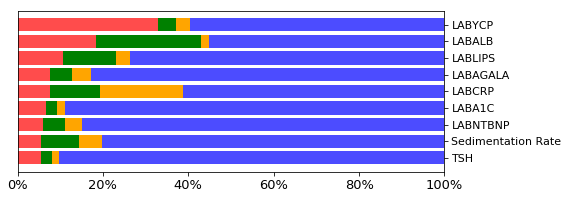

<Figure size 432x288 with 0 Axes>

In [63]:


fig, ax = plt.subplots(figsize=(8, .3 + 5.7/20.*len(labs))) #5+ 3./20.*len(labs)
# 8, 3.435 for guideline
# 8, 6 for freq labs
# 6 - 3.435 = 2.565
# Size for saturation is 7, 2.565 ?
labs = sorted(labs, key=lambda x: lab2stats[x]['< 24 hrs'] / lab2stats[x]['total']) #, reverse=True

for i, lab in enumerate(labs):

    time_since_last_order_binned = lab2stats[lab]


    for time, cnt in time_since_last_order_binned.items():
        if time == 'total':
            continue
        if scale_method == 'normalize':
            time_since_last_order_binned[time] = cnt/time_since_last_order_binned['total']

        elif scale_method == 'by_scale':
            time_since_last_order_binned[time] = cnt*scale

    if i == 0:
        plot_order_intensities_barh(lab, time_since_last_order_binned,
                                         columns=columns,
                                         labeling=True,
                                         lab_ind=i,
                                         scale=scale)
    else:
        plot_order_intensities_barh(lab, time_since_last_order_binned,
                                         columns=columns,
                                         labeling=False,
                                         lab_ind=i,
                                         scale=scale)

if scale_method == 'normalize':
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in np.linspace(0,1,num=6)])
    plt.tick_params('x', labelsize=13)
    plt.tick_params('y', labelsize=11)
    plt.xlim([0,1])
else:
    plt.tick_params('x', labelsize=15) #12
    plt.tick_params('y', labelsize=13) #10

if result_label != 'labs_guideline':
    plt.xlabel('Number of orders per 1000 patient encounters', fontsize=14) #'Order number between 2014/07-2017/06'

if include_legend:
    plt.legend(prop={'size': 12})
else:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    pass

plt.tight_layout()
cached_result_folderpath = cached_result_foldername + 'Order_Intensities_%s_%i_%s.png'%(lab_type,ind_toplot,result_label)

if to_annotate_percentages:
    cached_result_folderpath.replace('.png', '_formal_1.png')
    # plt.xlim([0,5000])

plt.show()
plt.savefig(cached_result_folderpath)
plt.clf()

## Normality Saturations

In [18]:
max_repeat = 5
labs=['K', 'CR', 'NA', 'WBC', 'HGB']

if not os.path.exists(figure2_folderpath):
    os.mkdir(figure2_folderpath)

if os.path.exists(figure2_folderpath + 'lab2cnt.csv'):
    lab2cnt_pd = pd.read_csv(figure2_folderpath + 'lab2cnt.csv', keep_default_na=False)\
        .set_index('lab')
    lab2cnt_pd.columns = lab2cnt_pd.columns.astype(int)
    lab2cnt = lab2cnt_pd.to_dict(orient='index')

    lab2frac_pd = pd.read_csv(figure2_folderpath + 'lab2frac.csv', keep_default_na=False).set_index('lab')
    lab2frac_pd.columns = lab2frac_pd.columns.astype(int)
    lab2frac = lab2frac_pd.to_dict(orient='index')
else:

    lab2cnt, lab2frac = {}, {}
    import pickle
    cur_cnt_folderpath = 'Normality_Saturations_Cnts'
    if not os.path.exists(cur_cnt_folderpath):
        os.mkdir(cur_cnt_folderpath)

    def save_obj(obj, path):
        with open(path, 'wb') as f:
            pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

    def load_obj(path):
        with open(path, 'rb') as f:
            return pickle.load(f)

    for lab in labs:
        print 'Getting Normality Saturations for %s..' % lab

        cur_dict_name = "cur_dict_%s.pkl"%lab
        cur_dict_path = os.path.join(cur_cnt_folderpath, cur_dict_name)
        if not os.path.exists(cur_dict_path):
            df_lab = stats_utils.get_queried_lab(lab, lab_type, time_limit=stats_utils.DEFAULT_TIMELIMIT)

            if lab_type=='panel':
                df_lab = df_lab[df_lab['order_status'] == 'Completed']

            cur_dict = stats_utils.get_prevweek_normal__dict(df_lab, lab_type)

            save_obj(cur_dict, cur_dict_path)
        else:
            cur_dict = load_obj(cur_dict_path)

        normal_fractions = {}
        record_counts = {}
        for x in range(0, max_repeat + 1):
            if x in cur_dict:
                record_count = len(cur_dict[x])
                normal_fraction = np.divide(sum(cur_dict[x]), float(record_count))
            else:
                record_count = 0
                normal_fraction = float('nan')

            record_counts[x] = record_count
            normal_fractions[x] = (normal_fraction)
        lab2cnt[lab] = record_counts
        lab2frac[lab] = normal_fractions

    df_cnts = pd.DataFrame.from_dict(lab2cnt, orient='index').reset_index().rename(columns={'index': 'lab'})
    df_fracs = pd.DataFrame.from_dict(lab2frac, orient='index').reset_index().rename(columns={'index': 'lab'})
    #
    # print df_cnts
    # print df_fracs
    # quit()

    df_cnts.to_csv(figure2_folderpath + 'lab2cnt.csv', index=False)
    df_fracs.to_csv(figure2_folderpath + 'lab2frac.csv', index=False)

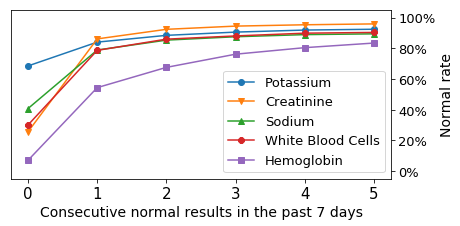

<Figure size 432x288 with 0 Axes>

In [20]:
fig, ax = plt.subplots(figsize=(6.5, 3.25)) #6, 4.5 # 7, 2.565 #6.5, 3.75

#, '<', '>'
marker_types = ('o', 'v', '^', '8', 's', 'P', '*', 'X', 'D', 'd')

for k, lab in enumerate(labs):  # :

    non_empty_inds = []
    for i in range(0,max_repeat+1):
        if lab2frac[lab][i]=='':
            break
        non_empty_inds.append(i)
    y_s = [float(lab2frac[lab][i]) for i in non_empty_inds]
    plt.plot(non_empty_inds, y_s, '-'+marker_types[k], label=labDescriptions[lab])
    # l2, = plt.scatter(non_empty_inds, y_s, marker=marker_types[k])
    # plt.plot(y_s[0], '-'+marker_types[k], color=l2.get_color(), markerfacecolor=l1.get_color(), label='My plots')

plt.xticks(range(0, max_repeat + 1))
plt.xlabel('Consecutive normal results in the past 7 days', fontsize=14)
plt.yticks([0,0.2,0.4,0.6,0.8,1], ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.tick_params('x', labelsize=15)  # 12
plt.tick_params('y', labelsize=13)  # 10
plt.ylabel("Normal rate", fontsize=14)
plt.ylim([-0.05, 1.05])
plt.legend(fontsize=13)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.tight_layout()

plt.show()
plt.savefig(figure2_folderpath + 'Negative_Saturations_%s'%(lab_type))
plt.clf()